# 75.06/95.58 Organización de Datos
# Análisis exploratorio: Real or Not? NLP with Disaster Tweets

### Carga de librerías

In [5]:
import pandas as pd

import numpy as np
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS #conda install -c conda-forge wordcloud 
from  imageio import imread
import nltk, os, re, string
from nltk.corpus import stopwords
import string
import squarify # pip install squarify


%matplotlib inline

### Carga de datos
Debido a que se trabajara con grandes cantidades de data, se definió convenientemente los tipos de datos de los datos pasados por archivo para no sobrecargar al parser de los archivos csv y ahorrar espacio de memoria.

#### Archivo sample

In [6]:
sample = pd.read_csv("sample_submission.csv")
# Se observa que es un data frame que sólo contiene informacion sobre los ids

#### Archivo test

In [7]:
dtype_test = {"id": np.int32, "keyword": "category"}
test = pd.read_csv("test.csv", dtype = dtype_test)

#### Archivo train

In [8]:
dtype_train = {"id": np.int32, "keyword": "category", "target" : bool}
train = pd.read_csv("train.csv", dtype = dtype_train)

# Limpieza de datos

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        7613 non-null   int32   
 1   keyword   7552 non-null   category
 2   location  5080 non-null   object  
 3   text      7613 non-null   object  
 4   target    7613 non-null   bool    
dtypes: bool(1), category(1), int32(1), object(2)
memory usage: 172.8+ KB


In [10]:
#vemos cuantos nulos hay por columna
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
#porcentaje de datos faltantes
((train.isnull().sum() / len(train))*100).sort_values(ascending=False)

location    33.272035
keyword      0.801261
target       0.000000
text         0.000000
id           0.000000
dtype: float64

## 1. Limpieza campo 'keyword'

In [12]:
#analizo los valores que llegan en 'keyword'
train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [13]:
#armo lista con los keywords que ya existen
train_sin_keywords_nulos = train.dropna(subset=['keyword'])
np.unique(train_sin_keywords_nulos.keyword)

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

In [14]:
#limpio los que tienen "%20", parece que deberia ir un espacio ahi
train["keyword"] = train["keyword"].str.replace('%20',' ')
train_sin_keywords_nulos = train.dropna(subset=['keyword'])
keywords = np.unique(train_sin_keywords_nulos.keyword)
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desolate',

In [15]:
#miro los tweets que vienen sin keyword
train[train['keyword'].isnull()]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,True
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,True
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,True
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,True


In [16]:
#completo aquellos que en el texto contengan alguna palabra de la lista keywords
for keyword in keywords:
    train.loc[(train['text'].str.contains(keyword, case=False) & train['keyword'].isnull()), 'keyword'] = keyword

In [17]:
#no se si convendria hacer fillna o no
train[train['keyword'].isnull()]
#df.fillna(value={'keyword': ''})

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,False
16,24,NaN,NaN,I love fruits,False
17,25,NaN,NaN,Summer is lovely,False
18,26,NaN,NaN,My car is so fast,False
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,False
20,31,NaN,NaN,this is ridiculous....,False
21,32,NaN,NaN,London is cool ;),False
22,33,NaN,NaN,Love skiing,False
23,34,NaN,NaN,What a wonderful day!,False
24,36,NaN,NaN,LOOOOOOL,False


In [18]:
train.keyword.value_counts()

fatalities             45
fire                   44
siren                  42
earthquake             42
armageddon             42
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: keyword, Length: 221, dtype: int64

In [19]:
train.keyword.isnull().sum()

16

# Análisis de datos

## 1. Análisis palabras y caracteres especiales

Creo un data frame al que le cálculo ciertas cantidades.

In [21]:

palabras = pd.DataFrame()

# Número de palabras usadas
palabras['#palabras'] = train['text'].apply(lambda x: len(x.split()))

# Número de palabras únicas
palabras['#palabras_unicas'] =  train['text'].apply(lambda x: len(set(x.split())))

# Número de caracteres
palabras['#caracteres'] =  train['text'].apply(lambda x: len(x))

# Número de caracteres de puntuación
def punct(text):
    return(len([w for w in text.split() if w in list(string.punctuation)]))
palabras['#putuacion'] = train['text'].apply(lambda x: punct(x))

# Número de stopwords
stopword = stopwords.words('english')
def stop(text):
    return(len([w for w in text.split() if w in stopword]))
palabras['#stopwords'] = train['text'].apply(lambda x: stop(x))

# Promedio de longitud del tweet
def length(text):
    return(np.mean([len(w) for w in text.split()]))
palabras['promedio_len_word'] = train['text'].apply(lambda x: length(x))



LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\Ron Heyes/nltk_data'
    - 'C:\\Users\\Ron Heyes\\anaconda3\\nltk_data'
    - 'C:\\Users\\Ron Heyes\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\Ron Heyes\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Ron Heyes\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
palabras.head(5)

## 2. N gramans

In [7]:
'''## H. NUMBER OF MOST FREQUENT TERMS
token = nltk.word_tokenize(''.join(train.STORY))
frequent = nltk.FreqDist(token)
frequent.most_common(15)'''

"## H. NUMBER OF MOST FREQUENT TERMS\ntoken = nltk.word_tokenize(''.join(train.STORY))\nfrequent = nltk.FreqDist(token)\nfrequent.most_common(15)"

In [8]:
'''## REMOVING PUNCTUATION AND STOPWORDS FROM MOST FREQUENT WORDS
for sym in string.punctuation:
    del frequent[sym]
for word in stopword:
    del frequent[word]
frequent.most_common(15)'''

'## REMOVING PUNCTUATION AND STOPWORDS FROM MOST FREQUENT WORDS\nfor sym in string.punctuation:\n    del frequent[sym]\nfor word in stopword:\n    del frequent[word]\nfrequent.most_common(15)'

##  3. Análisis de hashtags

Funciones auxiliares:

In [22]:
'''Recibe un tweet en forma de string y devuelve otro string con sus hashtags con el separador ',' de por medio
y en minuscula.'''
def get_hashtags(tweet):
    res = ""
    words = tweet.split(' ')
    for word in words:
        if(word != "" and word[0]=='#'):
            res += word.lower() +" "
    return res[:-1]

'''Recibe un string y devuelve la cantidad de substrings que son separados por un delimitador ',' .'''
def cant_substrings(string):
    cant = 0
    delimiter =  '#'
    for c in string:
        if(c == delimiter):
            cant += 1
    return cant

Se crea un nuevo dataframe especialmente para los hashtags.

In [23]:
df_hashtags = train[['id', 'text', 'target']]
df_hashtags['hashtags'] = df_hashtags['text'].apply(get_hashtags).astype(str)
df_hashtags['cant_hashtags'] = df_hashtags['text'].apply(cant_substrings)

C:\Users\Ron Heyes\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df_hashtags_only = df_hashtags.loc[df_hashtags['hashtags']!='']
df_sin_hashtags = df_hashtags.loc[df_hashtags['hashtags']=='']

### 3.1 Cantidad de tweets con hashtags

Se calcula la cantidade de tweets con y sin hashtag.

In [25]:
cant_tweets = df_hashtags.agg('count')[0]
cant_tweets_con_hashtag = df_hashtags_only.agg('count')[0]
cant_tweets_sin_hashtag = cant_tweets - cant_tweets_con_hashtag

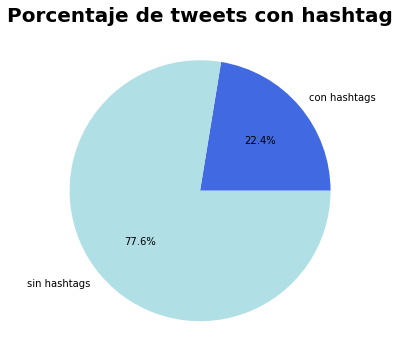

In [26]:
fig,ax1 = plt.subplots(1, 1, figsize=(6, 6))

labels = 'con hashtags', 'sin hashtags'
sizes = [cant_tweets_con_hashtag, cant_tweets_sin_hashtag]
colors = ['#4169E1', '#B0E0E6']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Porcentaje de tweets con hashtag", loc='center', fontsize =20, fontweight = 'bold')


plt.show()

### 3.2 Hashtags más usados

Se genera un texto con todos los hashtags

In [27]:
words = '' 
  
index = df_hashtags_only.index.tolist()
for i in index:
    words += df_hashtags_only.loc[i, "hashtags"] + " "

Se grafica de hashtags más usados usando un wordcloud

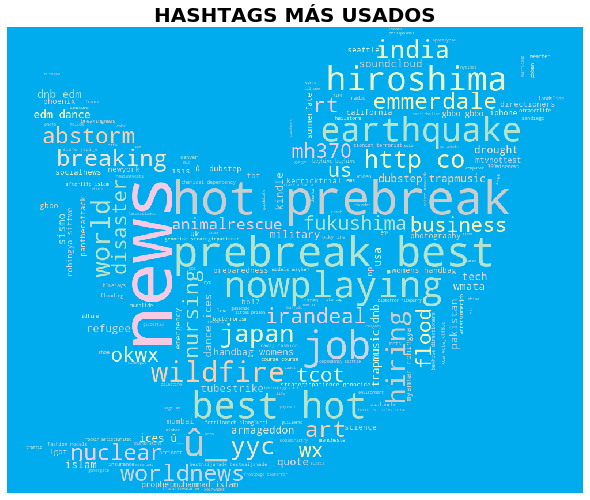

In [28]:
twitter_mask = imread('twitter.png')

wordcloud = WordCloud(width = 200, height = 200, 
                background_color ='#00acee', 
                min_font_size = 7,
                mask=twitter_mask,
                colormap= "Pastel2").generate(words) 
  
plt.figure(figsize = (8, 8))
plt.title("HASHTAGS MÁS USADOS", loc='center', fontsize =20, fontweight = 'bold')
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Se crea un diccionario con los hashtags y su cantidad de apariciones en total.

In [29]:
def get_df_cant_hashtags(df):
    
    dict_hashtag = {}
    for row in df["hashtags"]:
        hashtags = row.split(" ")
        for h in hashtags:
            if(h in dict_hashtag):
                dict_hashtag[h] += 1
            else:
                dict_hashtag[h] = 1
    
    df_hashtags_ranking = pd.DataFrame.from_dict(dict_hashtag, orient ="index")
    df_hashtags_ranking.columns = ['cant']
    df_hashtags_ranking.sort_values("cant", ascending = False, inplace =True)
    
    return df_hashtags_ranking

In [30]:
df_hashtags_ranking =  get_df_cant_hashtags(df_hashtags_only)

Se crea un ranking de los hashtags más usados.

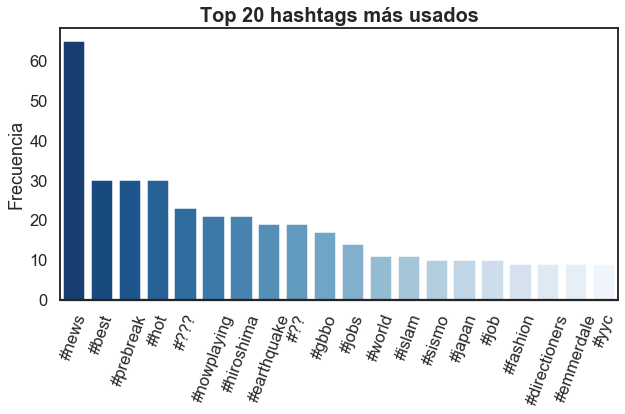

In [31]:
sns.set(style="white", context="talk")

top = 20
fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))

labels = df_hashtags_ranking.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_hashtags_ranking["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Blues_r", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Frecuencia")
ax1.set_xticklabels(labels, rotation = 70)
ax1.set_title("Top 20 hashtags más usados", loc='center', fontsize =20, fontweight = 'bold')

plt.show()

### 4.3  Hashtags mas usados en tweets falsos y reales

Observamos que auqellos tweets analizados sin hashtags son 58.87% falsos y 41.13% reales.

In [32]:
df_sin_hashtags["target"].value_counts()

False    3477
True     2429
Name: target, dtype: int64

Separo por aquellos tweets con hashtag los reales de los falsos:

In [33]:
df_hashtags_real = df_hashtags_only.loc[df_hashtags['target']==True]
df_hashtags_falso = df_hashtags_only.loc[df_hashtags['target']==False]

In [34]:
df_hashtags_ranking_real =  get_df_cant_hashtags(df_hashtags_real)
df_hashtags_ranking_falso =  get_df_cant_hashtags(df_hashtags_falso)

C:\Users\Ron Heyes\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ron Heyes\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


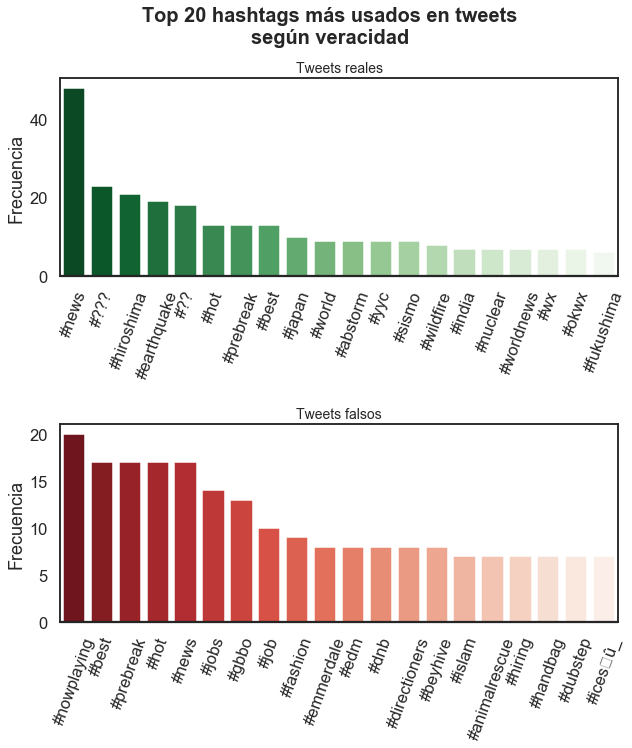

In [35]:
sns.set(style="white", context="talk")

top = 20
fig,axes = plt.subplots(2, 1, figsize=(10, 10))

plt.subplots_adjust(hspace = 0.75)
plt.suptitle("Top 20 hashtags más usados en tweets\nsegún veracidad", fontsize =20, fontweight = 'bold')

# Tweets reales
labels = df_hashtags_ranking_real.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_hashtags_ranking_real["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Greens_r", ax=axes[0])
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel("Frecuencia")
axes[0].set_xticklabels(labels, rotation = 70)
axes[0].set_title("Tweets reales", loc='center', fontsize =14)

# Tweets falsos

labels = df_hashtags_ranking_falso.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_hashtags_ranking_falso["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Reds_r", ax=axes[1])
axes[1].axhline(0, color="k", clip_on=False)
axes[1].set_ylabel("Frecuencia")
axes[1].set_xticklabels(labels, rotation = 70)
axes[1].set_title("Tweets falsos", loc='center', fontsize =14)

plt.show()

### 3.4 Análisis de cantidad de hashtags

In [36]:
cant_sin_hashtags = df_sin_hashtags["target"].value_counts()

In [37]:
cant_hashtags_falso = df_hashtags_ranking_falso["cant"].value_counts()
cant_hashtags_real = df_hashtags_ranking_real["cant"].value_counts()

In [38]:
cant_hashtags_falsos_l =  [cant_sin_hashtags[0]]+cant_hashtags_falso[:2].tolist()\
+ [sum(cant_hashtags_falso[2:])]
cant_hashtags_real_l = [cant_sin_hashtags[1]]+cant_hashtags_real[:2].tolist()\
+ [sum(cant_hashtags_real[2:])]

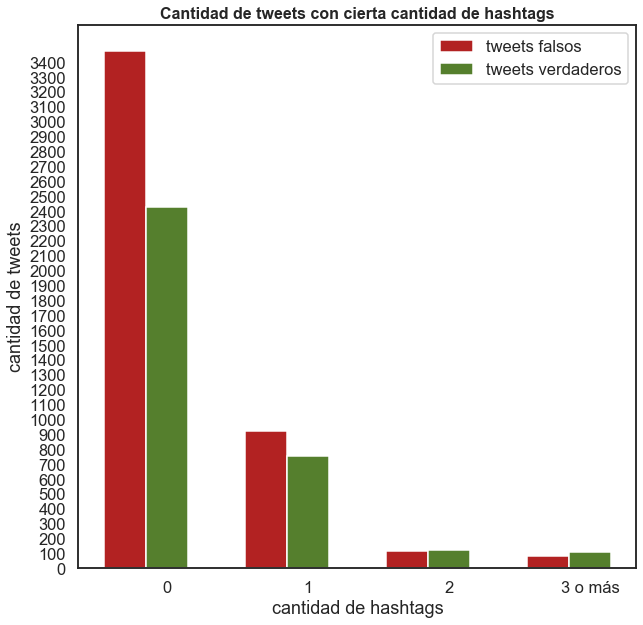

In [39]:

fig,ax1 = plt.subplots(1, 1, figsize=(10, 10))

barWidth = 0.3

r1 = np.arange(len(cant_hashtags_falsos_l))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, cant_hashtags_falsos_l, color='#B22222', width=barWidth, edgecolor='white', label='tweets falsos')
plt.bar(r2, cant_hashtags_real_l, color='#557f2d', width=barWidth, edgecolor='white', label='tweets verdaderos')
 
plt.xlabel('cantidad de hashtags')
plt.xticks([r + barWidth for r in range(len(cant_hashtags_falsos_l))], ['0', '1', '2', '3 o más'])

plt.ylabel('cantidad de tweets')
plt.yticks(range(0,3500,100))

plt.title("Cantidad de tweets con cierta cantidad de hashtags", fontweight = "bold", fontsize=16)

plt.legend()
plt.show()

## Tweets con imágen

In [40]:
servidor ='http://t.co' #esel servidor de twitter 
# df_tweet_imagen = train.loc[(servidor in train["text"])]
# for tweet in train["text"]:
#    print(servidor in tweet)

In [41]:
train.head(20)

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,True
3,6,evacuation,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,fire,NaN,Just got sent this photo from Ruby #Alaska as ...,True
5,8,fire,NaN,#RockyFire Update => California Hwy. 20 closed...,True
6,10,disaster,NaN,#flood #disaster Heavy rain causes flash flood...,True
7,13,fire,NaN,I'm on top of the hill and I can see a fire in...,True
8,14,emergency,NaN,There's an emergency evacuation happening now ...,True
9,15,tornado,NaN,I'm afraid that the tornado is coming to our a...,True


In [2]:
#comentario Dani: ojo que no todos los links son imagenes, aca un ejemplo

import requests

shorturl = 'http://t.co/LZmL1xB2nH'
url = requests.get(shorturl)

print("""
The shortened URL forwards to:

    %s
""" % url.url)


The shortened URL forwards to:

    https://wildfiretoday.com/2015/06/29/homes-burn-in-wenatchee-washington-wildfire/



In [43]:
real_train_location = train.loc[train['target']==1]
real_train_location.head(1)

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,True


In [44]:
fake_train_location = train.loc[train['target']==0]
fake_train_location.head(1)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,False


In [45]:
tweet_type = [['real', 'fake']]

comparisson = pd.DataFrame(index = tweet_type, columns = [['NaN values(%)','non-NaN values(%)']])

comparisson.iloc[0,0]=real_train_location['location'].isnull().sum()/real_train_location['target'].count()*100
comparisson.iloc[1,0]=fake_train_location['location'].isnull().sum()/fake_train_location['target'].count()*100
comparisson.iloc[0,1]=real_train_location['location'].notnull().sum()/real_train_location['target'].count()*100
comparisson.iloc[1,1]=fake_train_location['location'].notnull().sum()/fake_train_location['target'].count()*100

comparisson

,NaN values(%),non-NaN values(%)
real,32.8646,67.1354
fake,33.579,66.421


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014BF30FF408>,
      dtype=object)

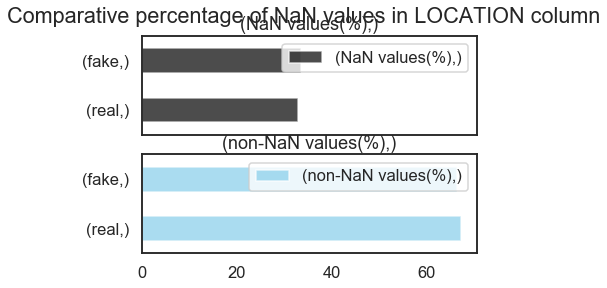

In [46]:
comparisson.plot(kind='barh', alpha=0.7, title='Comparative percentage of NaN values in LOCATION column', 
                 color = ('black','skyblue'), subplots = True)

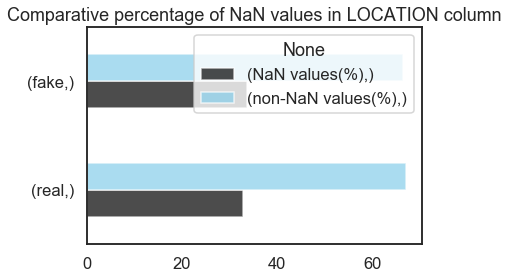

In [47]:
comparisson.plot(kind='barh', alpha=0.7, title='Comparative percentage of NaN values in LOCATION column', 
                 color = ('black','skyblue'))